In [86]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [4]:
@njit('f8(f8[:], f8[:], i8[:], i8[:], i8)', cache=True)
def lr_statistic(dur_1, dur_2, cens_1, cens_2, weightings):
    times = np.unique(np.hstack((dur_1, dur_2)))
    dur_1 = np.searchsorted(times, dur_1) + 1
    dur_2 = np.searchsorted(times, dur_2) + 1
    times_range = np.array([1, times.shape[0]], dtype=np.int32)

    bins = times_range[1] - times_range[0] + 1
    n_1_j = np.histogram(dur_1, bins=bins, range=times_range)[0]
    n_2_j = np.histogram(dur_2, bins=bins, range=times_range)[0]
    O_1_j = np.histogram(dur_1 * cens_1, bins=bins, range=times_range)[0]
    O_2_j = np.histogram(dur_2 * cens_2, bins=bins, range=times_range)[0]

    N_1_j = np.cumsum(n_1_j[::-1])[::-1]
    N_2_j = np.cumsum(n_2_j[::-1])[::-1]
    ind = np.where(N_1_j * N_2_j != 0)
    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = O_1_j[ind]
    O_2_j = O_2_j[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    res[:, 0] = 1.0
    # if np.any(N_j <= 1):
    #     return 0.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    logrank = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    return logrank


def weight_lr_fast(dur_A, dur_B, cens_A=None, cens_B=None, weightings=""):
    try:
        if cens_A is None:
            cens_A = np.ones(dur_A.shape[0])
        if cens_B is None:
            cens_B = np.ones(dur_B.shape[0])
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4}
        weightings = d.get(weightings, 1)
        logrank = lr_statistic(dur_A.astype("float64"),
                               dur_B.astype("float64"),
                               cens_A.astype("int64"),
                               cens_B.astype("int64"),
                               np.int64(weightings))
        return logrank
    except Exception as err:
        return 0.0
    
def logrank(durations_A, durations_B, event_observed_A=None, event_observed_B=None):
    return weight_lr_fast(durations_A, durations_B, event_observed_A, event_observed_B)

In [181]:
def optimal_criter_split(arr_nan, left, right, criterion):
    none_to = 0
    max_stat_val = 1.0
    if arr_nan.shape[1] > 0:
        left_and_nan = np.hstack([left, arr_nan])
        right_and_nan = np.hstack([right, arr_nan])
        a = criterion(left_and_nan[1], right[1], left_and_nan[0], right[0])
        b = criterion(left[1], right_and_nan[1], left[0], right_and_nan[0])
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
#         print(a, b)
    else:
        max_stat_val = criterion(left[1], right[1], left[0], right[0])
    return (max_stat_val, none_to)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh+nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh+nan_sh, r_sh)
    return attrs


def get_cont_attrs(uniq_set, arr_notnan, arr_nan, min_samples_leaf, criterion, 
                   signif_val, thres_cont_bin_max):
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(arr_notnan[0], [i/float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:  # Set intermediate points
        uniq_set = (uniq_set[:-1] + uniq_set[1:])*0.5
    uniq_set = list(set(np.round(uniq_set, 3)))
    attr_dicts = []
    for value in uniq_set:
        # Filter by attr value
        ind = arr_notnan[0] >= value
        left = arr_notnan[1:, np.where(ind)[0]]  #.astype(np.int32)  # inaccuracy in stat values
        right = arr_notnan[1:, np.where(~ind)[0]]  # .astype(np.int32)
        
        if min(left.shape[1], right.shape[1]) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split(arr_nan, left, right, criterion)
        if max_stat_val >= signif_val:
            attr_loc = get_attrs(max_stat_val, value, none_to,
                                 left.shape[1], right.shape[1], arr_nan.shape[1])
            attr_dicts.append(attr_loc)
    return attr_dicts


def get_categ_attrs(uniq_set, arr_notnan, arr_nan, min_samples_leaf, criterion, signif_val):
    attr_dicts = []
    pairs_uniq = power_set_nonover(uniq_set)
    for l, r in pairs_uniq:
        left = arr_notnan[1:, np.isin(arr_notnan[0], l)].astype(np.int32)
        right = arr_notnan[1:, np.isin(arr_notnan[0], r)].astype(np.int32)
        if min(left.shape[1], right.shape[1]) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split(arr_nan, left, right, criterion)
        if max_stat_val >= signif_val:
            attr_loc = get_attrs(max_stat_val, [list(l), list(r)], none_to,
                                 left.shape[1], right.shape[1], arr_nan.shape[1])
            attr_dicts.append(attr_loc)
    return attr_dicts


def best_attr_split(arr, criterion="logrank", type_attr="cont", thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
#     criterion = crit.CRITERIA_DICT.get(criterion, None)
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2*min_samples_leaf:
        return best_attr

    ind = np.isnan(arr[0])
    arr_nan = arr[1:, np.where(ind)[0]].astype(np.int32)
    arr_notnan = arr[:, np.where(~ind)[0]]
    
    if type_attr == "woe":
        arr_notnan[0], descr_np = transform_woe(arr_notnan[0], arr_notnan[1])
        
    
    uniq_set = np.unique(arr_notnan[0])
    
    if type_attr == "categ" and uniq_set.shape[0] > 0:
        attr_dicts = get_categ_attrs(uniq_set, arr_notnan, arr_nan,
                                     min_samples_leaf, logrank, signif_stat)
    else:
        attr_dicts = get_cont_attrs(uniq_set, arr_notnan, arr_nan,
                                    min_samples_leaf, logrank, signif_stat, thres_cont_bin_max)
    
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" >= {best_attr['values']}", f" < {best_attr['values']}"]
        elif type_attr == "categ":
            best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe":
            ind = descr_np[1] >= best_attr["values"]
            l, r = list(descr_np[0, np.where(ind)[0]]), list(descr_np[0, np.where(~ind)[0]])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
        if verbose > 0:
            print(best_attr["p_value"], len(uniq_set))
    return best_attr

### NEW SPLITTING

In [182]:
@njit('f8(i8[:], i8[:], i8[:], i8[:], i8)', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2, weightings):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    ind = np.where(N_1_j * N_2_j != 0)
    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    res[:, 0] = 1.0
    
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    stat_val = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    return stat_val

def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4}
        weightings = d.get(weightings, 1)
        logrank = lr_hist_statistic(time_hist_1.astype("int64"),
                                    time_hist_2.astype("int64"),
                                    cens_hist_1.astype("int64"),
                                    cens_hist_2.astype("int64"),
                                    np.int64(weightings))
        return logrank
    except Exception as err:
        return 0.0
    
def logrank_hist(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None):
    return weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2)

def optimal_criter_split_hist(left_time_hist, left_cens_hist, 
                         right_time_hist, right_cens_hist,
                         na_time_hist, na_cens_hist, criterion):
    none_to = 0
    max_stat_val = 1.0
    if na_time_hist.shape[0] > 0:
        a = criterion(left_time_hist + na_time_hist, right_time_hist, 
                      left_cens_hist + na_cens_hist, right_cens_hist)
        b = criterion(left_time_hist, right_time_hist + na_time_hist, 
                      left_cens_hist, right_cens_hist + na_cens_hist)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
#         print(a, b)
    else:
        max_stat_val = criterion(left_time_hist, right_time_hist, 
                                 left_cens_hist, right_cens_hist)
    return (max_stat_val, none_to)

def split_time_to_bins(time):
    return np.searchsorted(np.unique(time), time)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh+nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh+nan_sh, r_sh)
    return attrs

In [183]:
def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
    criterion = crit.CRITERIA_DICT.get(criterion, None)
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2*min_samples_leaf:
        return best_attr
    vals = arr[0]
    cens = arr[1]
    dur = arr[2]
    
    dur = split_time_to_bins(dur)
    time_bins = np.unique(dur)
    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i/float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:])*0.5
    uniq_set = np.unique(np.round(uniq_set, 3))
    index_vals_bin = np.digitize(vals_notna, uniq_set)

    # find global hist by times
    na_time_hist = np.bincount(dur[ind])
    na_cens_hist = np.bincount(dur[ind], weights=cens[ind])

    right_time_hist = np.bincount(dur_notna)
    right_cens_hist = np.bincount(dur_notna, weights=cens_notna)
    left_time_hist = np.zeros_like(dur_notna, dtype=np.int32)
    left_cens_hist = left_time_hist.copy()
    
    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    # for each split values get branches
    attr_dicts = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist = np.bincount(dur_notna, weights=curr_mask).astype("int32")
        curr_cens_hist = np.bincount(dur_notna, weights=cens_notna*curr_mask).astype("int32")
        left_time_hist += curr_time_hist
        left_cens_hist += curr_cens_hist
        right_time_hist -= curr_time_hist
        right_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n
        
        if min(num_l, num_r) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split_hist(left_time_hist, left_cens_hist, 
                                                     right_time_hist, right_cens_hist,
                                                     na_time_hist, na_cens_hist, logrank_hist)
        
        if max_stat_val >= signif_stat:
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
            attr_dicts.append(attr_loc)
#         print(uniq_set[u], max_stat_val)
    
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        elif type_attr == "categ":
            best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe":
            ind = descr_np[1] >= best_attr["values"]
            l, r = list(descr_np[0, np.where(ind)[0]]), list(descr_np[0, np.where(~ind)[0]])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
        if verbose > 0:
            print(best_attr["p_value"], len(uniq_set))
    return best_attr

In [184]:
def miss_hist_best_attr_split(arr, criterion="logrank", type_attr="cont", thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
    criterion = crit.CRITERIA_DICT.get(criterion, None)
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2*min_samples_leaf:
        return best_attr
    vals = arr[0]
    cens = arr[1]
    dur = arr[2]
    
    dur = split_time_to_bins(dur)
    time_bins = np.unique(dur)
#     print(time_bins)
    
    bins = dur
    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i/float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:])*0.5
    uniq_set = np.unique(np.round(uniq_set, 3))
    index_vals_bin = np.digitize(vals_notna, uniq_set)

    # find global hist by times
    na_time_hist = np.histogram(dur[ind], bins = time_bins)[0]
    na_cens_hist = np.histogram(dur[ind], bins = time_bins, weights = cens[ind])[0].astype("int32")

    right_time_hist = np.histogram(dur_notna, bins = time_bins)[0]
    right_cens_hist = np.histogram(dur_notna, bins = time_bins, weights = cens_notna)[0].astype("int32")
    left_time_hist = np.zeros_like(right_time_hist, dtype = np.int32)
    left_cens_hist = left_time_hist.copy()
    
    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    # for each split values get branches
    attr_dicts = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist = np.histogram(dur_notna[curr_mask], bins = time_bins)[0]
        curr_cens_hist = np.histogram(dur_notna[curr_mask], bins = time_bins, weights=cens_notna[curr_mask])[0].astype("int32")
        left_time_hist += curr_time_hist
        left_cens_hist += curr_cens_hist
        right_time_hist -= curr_time_hist
        right_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n
        
        if min(num_l, num_r) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split_hist(left_time_hist, left_cens_hist, 
                                                     right_time_hist, right_cens_hist,
                                                     na_time_hist, na_cens_hist, logrank_hist)
        
        if max_stat_val >= signif_stat:
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
            attr_dicts.append(attr_loc)
#         print(uniq_set[u], max_stat_val)
    
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" >= {best_attr['values']}", f" < {best_attr['values']}"]
        elif type_attr == "categ":
            best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe":
            ind = descr_np[1] >= best_attr["values"]
            l, r = list(descr_np[0, np.where(ind)[0]]), list(descr_np[0, np.where(~ind)[0]])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
        if verbose > 0:
            print(best_attr["p_value"], len(uniq_set))
    return best_attr

### Тестирование

In [56]:
dur = np.random.uniform(0, 10000, 10000)
cens = np.random.choice(2, 10000)
vals = np.random.uniform(100, 8000, 10000)

arr = np.vstack([vals, cens, dur])

In [97]:
hist_best_attr_split(arr)

182.493 5.6360321044921875
271.021 2.5912275314331055
347.896 2.0125250816345215
415.59 0.21973085403442383
492.347 1.6572258472442627
574.023 1.9961357116699219
665.152 1.3391757011413574
744.072 0.6490407586097717
806.195 0.642905592918396
879.519 1.361128330230713
968.252 0.8618687391281128
1052.857 1.8673123121261597
1131.694 0.7261466979980469
1197.958 1.6209357976913452
1276.037 1.6727993488311768
1353.387 1.5697966814041138
1432.374 0.6530634760856628
1516.655 1.1923967599868774
1601.508 0.7626166343688965
1697.198 0.3329196274280548
1772.567 0.254820853471756
1855.971 0.23110482096672058
1933.206 0.075136698782444
2024.433 0.02039954625070095
2103.029 0.0016825671773403883
2179.196 0.035860273987054825
2264.373 0.08952926099300385
2340.105 0.038424842059612274
2417.926 0.02317448891699314
2507.87 0.15453454852104187
2582.578 0.35974159836769104
2661.775 0.6719045042991638
2745.47 0.5109747052192688
2828.959 0.8455283641815186
2909.512 0.9068726301193237
2977.661 1.4601438045501

{'stat_val': 5.6360321044921875,
 'values': [' >= 182.493', ' < 182.493'],
 'pos_nan': [1, 0],
 'min_split': 100,
 'p_value': 1.741903386448486,
 'sign_split': 99}

In [90]:
%timeit best_attr_split(arr)

145 ms ± 852 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
%timeit hist_best_attr_split(arr)

28.3 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
profiler = cProfile.Profile()
profiler.enable()
hist_best_attr_split(arr)
profiler.disable()
stats_ = pstats.Stats(profiler).sort_stats('cumtime')
stats_.print_stats()
stats_.dump_stats('hist_output.pstats')

         3230 function calls (3218 primitive calls) in 0.034 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.033    0.017 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\IPython\core\interactiveshell.py:3362(run_code)
        2    0.000    0.000    0.033    0.017 {built-in method builtins.exec}
        1    0.000    0.000    0.033    0.033 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\2418375740.py:1(<cell line: 3>)
        1    0.006    0.006    0.033    0.033 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\3382176909.py:1(hist_best_attr_split)
       99    0.000    0.000    0.016    0.000 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\3474870837.py:48(optimal_criter_split_hist)
       99    0.000    0.000    0.016    0.000 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\3474870837.py:45(logrank_hist)
       99    0.001    0.000    0.016    0.000 C:\Users\vasili

In [72]:
profiler = cProfile.Profile()
profiler.enable()
best_attr_split(arr)
profiler.disable()
stats_ = pstats.Stats(profiler).sort_stats('cumtime')
stats_.print_stats()
stats_.dump_stats('old_output.pstats')

         2351 function calls (2342 primitive calls) in 0.152 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.152    0.076 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\IPython\core\interactiveshell.py:3362(run_code)
        2    0.000    0.000    0.152    0.076 {built-in method builtins.exec}
        1    0.000    0.000    0.152    0.152 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\327923047.py:1(<cell line: 3>)
        1    0.001    0.001    0.152    0.152 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\3775720439.py:70(best_attr_split)
        1    0.012    0.012    0.148    0.148 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\3775720439.py:30(get_cont_attrs)
       99    0.000    0.000    0.131    0.001 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_1692\3775720439.py:1(optimal_criter_split)
       99    0.000    0.000    0.131    0.001 C:\Users\vasiliev\AppDat

### COVID TEST

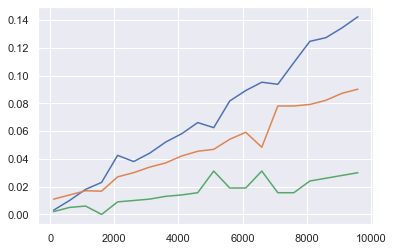

In [185]:
x = []
time_old = []
time_hist = []
time_hist_2 = []
res_old = []
res_hist = []
res_hist_2 = []
for i in range(100, 10000, 500):
    size_sample = i
    dur = np.random.uniform(0, 10000, size_sample)
    cens = np.random.choice(2, size_sample)
    vals = np.random.uniform(100, 8000, size_sample)
#     nan_index = np.random.uniform(0, 1, size_sample) < 0.25
#     vals[nan_index] = np.nan

    arr = np.vstack([vals, cens, dur])
    time_1 = time.time()
    res_old.append(best_attr_split(arr))
    time_2 = time.time()
    res_hist.append(miss_hist_best_attr_split(arr))
    time_3 = time.time()
    res_hist_2.append(hist_best_attr_split(arr))
    time_4 = time.time()
    
    x.append(size_sample)
    time_old.append(time_2 - time_1)
    time_hist.append(time_3 - time_2)
    time_hist_2.append(time_4 - time_3)
    
plt.plot(x, time_old)
plt.plot(x, time_hist)
plt.plot(x, time_hist_2)

In [186]:
res_hist

[{'stat_val': 5.319860935211182,
  'values': [' >= 1759.606', ' < 1759.606'],
  'pos_nan': [1, 0],
  'min_split': 22,
  'p_value': 1.6656118239066535,
  'sign_split': 79},
 {'stat_val': 2.776765823364258,
  'values': [' >= 728.123', ' < 728.123'],
  'pos_nan': [1, 0],
  'min_split': 54,
  'p_value': 9.277189137637086,
  'sign_split': 97},
 {'stat_val': 2.504786491394043,
  'values': [' >= 7337.361', ' < 7337.361'],
  'pos_nan': [1, 0],
  'min_split': 88,
  'p_value': 11.236585778078556,
  'sign_split': 99},
 {'stat_val': 6.600900173187256,
  'values': [' >= 7934.953', ' < 7934.953'],
  'pos_nan': [1, 0],
  'min_split': 16,
  'p_value': 1.009079513221688,
  'sign_split': 99},
 {'stat_val': 13.12096881866455,
  'values': [' >= 340.697', ' < 340.697'],
  'pos_nan': [1, 0],
  'min_split': 63,
  'p_value': 0.028908890172863706,
  'sign_split': 99},
 {'stat_val': 3.6657426357269287,
  'values': [' >= 7614.602', ' < 7614.602'],
  'pos_nan': [1, 0],
  'min_split': 130,
  'p_value': 5.498646727

In [187]:
res_hist_2

[{'stat_val': 5.319860935211182,
  'values': [' >= 1759.606', ' < 1759.606'],
  'pos_nan': [1, 0],
  'min_split': 22,
  'p_value': 1.6656118239066535,
  'sign_split': 79},
 {'stat_val': 2.776765823364258,
  'values': [' >= 728.123', ' < 728.123'],
  'pos_nan': [1, 0],
  'min_split': 54,
  'p_value': 9.277189137637086,
  'sign_split': 97},
 {'stat_val': 2.504786491394043,
  'values': [' >= 7337.361', ' < 7337.361'],
  'pos_nan': [1, 0],
  'min_split': 88,
  'p_value': 11.236585778078556,
  'sign_split': 99},
 {'stat_val': 6.600900173187256,
  'values': [' >= 7934.953', ' < 7934.953'],
  'pos_nan': [1, 0],
  'min_split': 16,
  'p_value': 1.009079513221688,
  'sign_split': 99},
 {'stat_val': 13.12096881866455,
  'values': [' >= 340.697', ' < 340.697'],
  'pos_nan': [1, 0],
  'min_split': 63,
  'p_value': 0.028908890172863706,
  'sign_split': 99},
 {'stat_val': 3.6657426357269287,
  'values': [' >= 7614.602', ' < 7614.602'],
  'pos_nan': [1, 0],
  'min_split': 130,
  'p_value': 5.498646727

In [170]:
best_attr_split(arr)

0.012018554843962193 1.2621216773986816
1.2063517570495605 0.3907041549682617
2.225672721862793 0.09063170105218887
2.1266400814056396 0.08699586242437363
0.5528597235679626 0.2683117389678955
1.35415518283844 0.017706800252199173
0.14702986180782318 2.3746490478515625
0.6457449793815613 0.7583029866218567
2.1756904125213623 0.09262961894273758
0.4394322335720062 0.3670446574687958
0.08932697772979736 1.440772533416748
0.3167608082294464 0.6216802597045898
2.7807183265686035 0.8623386025428772
2.2150657176971436 0.07173281162977219
0.03713637962937355 1.1001451015472412
0.7112388610839844 0.4183996319770813
0.8225005865097046 0.12459193915128708
2.230464220046997 0.09416273981332779
2.5576529502868652 0.23159891366958618
1.0307741165161133 0.4243181347846985
0.07158740609884262 2.0909390449523926
0.9771620631217957 0.1613612025976181
0.7744218707084656 0.6018855571746826
3.045586585998535 0.40208491683006287
0.4582228362560272 0.3488406836986542
0.5948648452758789 0.9096429944038391
1.

{'stat_val': 5.379920482635498,
 'values': [' >= 7834.53', ' < 7834.53'],
 'pos_nan': [0, 1],
 'min_split': 144,
 'p_value': 2.016610839128667,
 'sign_split': 99}

In [173]:
miss_hist_best_attr_split(arr)

[   0    1    2 ... 9597 9598 9599]
1.503159523010254 0.6181356310844421
2.5335397720336914 0.7460846900939941
3.3004097938537598 2.0785880088806152
2.25779128074646 0.1854497194290161
2.2154197692871094 0.14416904747486115
1.4172163009643555 0.08925037086009979
0.8911378979682922 0.5946558713912964
0.335670530796051 1.9832173585891724
0.5123960375785828 1.1683375835418701
0.560645341873169 0.9337142705917358
0.6183987855911255 0.7261718511581421
0.38054484128952026 1.2016608715057373
0.4137204587459564 1.0267033576965332
0.626259446144104 0.5504686236381531
0.819616436958313 0.2947755455970764
0.5416185259819031 0.5953559279441833
0.17472456395626068 1.4708095788955688
0.5204398036003113 0.5580786466598511
0.40899622440338135 0.7068030834197998
0.29928672313690186 0.8933134078979492
0.3340989947319031 0.7787036895751953
0.3071213662624359 0.7997142672538757
0.39467450976371765 0.6112209558486938
0.2747379541397095 0.8096060752868652
0.6110766530036926 0.3134606182575226
0.749753594398

{'stat_val': 5.384141445159912,
 'values': [' >= 7834.53', ' < 7834.53'],
 'pos_nan': [1, 0],
 'min_split': 144,
 'p_value': 2.0117379042776604,
 'sign_split': 99}